## Imports

In [20]:
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models

import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

from utils import save_checkpoint, load_checkpoint, print_examples

from get_loader import get_loader

# To automatically reload the external files 
# (after update)
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# THESE CELLS ARE FOR GETTING THE DIRECTORY STRUCTURE
import os

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            if os.path.isdir(f):
                print('{}{}'.format(subindent, f))
list_files('..')

../
    Image_annotations_Hindi/
        runs/
            flickr/
        __pycache__/
        .ipynb_checkpoints/
    Data/
        flickr8k/
            images/
                .ipynb_checkpoints/
            Utils/
                .ipynb_checkpoints/
            test_examples/
                .ipynb_checkpoints/
            .ipynb_checkpoints/
    Image_annotations_Eng/
        __pycache__/
        .ipynb_checkpoints/
    .ipynb_checkpoints/


## Download Dataset

**Make text file suitable to CSV**

In [2]:
# for Clean 1 Sentences
# f_in = "../Data/flickr8k/Clean-1Sentences.txt"
# f_out = "../Data/flickr8k/Clean-1Sentences_withComma.txt"

# for Clean 5 sentences
# f_in = "../Data/flickr8k/Clean-5Sentences.txt"
# f_out = "../Data/flickr8k/Clean-5Sentences_withComma.txt"

# with open(f_in, 'r') as fin: 
#     with open(f_out, 'w') as fout: 
#         for line in fin: 
#             line = line.replace(',', '')    # change all commas to spaces
#             fout.write(",".join(line.split(" ", 1)))   # change first space to comma

# add the keys also (image,caption) manually

## Define Encoder and Decoder

**Encoder for Image features**

In [21]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        
        self.train_CNN = train_CNN    # whether train or not
        
        # pretrained inception model
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        
        # set dropout and relu layers
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
    def forward(self, images):
        # find features of images using inception model
        features = self.inception(images)
        
        for name, param in self.inception.named_parameters(): 
            # fully connected weight or bias
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            
            else:
                param.requires_grad = self.train_CNN
        
        # return the value associated
        return self.dropout(self.relu(features)) 

**Decoder for Captions**

In [22]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim = 0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        
        return outputs

## Define Model

In [23]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
    
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)
    
    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs
    
    def caption_image(self, image, vocabulary, max_length = 50):
        result_caption = []
        
        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None
            
            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                
                predicted = output.argmax(1)
                
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)
                
                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break
        
        return [vocabulary.itos[idx] for idx in result_caption]

## Training Model

**Transformer**

In [25]:
transform = transforms.Compose(
[
    transforms.Resize((356, 356)),
    transforms.RandomCrop((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

**Get Dataset and train loader**

In [7]:
train_loader, dataset = get_loader(
    root_folder = "../Data/flickr8k/images",
#     annotation_file = "../Data/flickr8k/Clean-1Sentences_withComma.txt",      # more fast and similar results to 5 sentences
    annotation_file = "../Data/flickr8k/Clean-5Sentences_withComma.txt",
    transform = transform,
    num_workers = 2,
)

torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = True

# enlgish captions has more large vocabulary, 3000 words (with 5 threshold)

In [8]:
train_loader, dataset

(<torch.utils.data.dataloader.DataLoader at 0x7f1080f4c7c0>,
 <get_loader.FlickrDataset at 0x7f116c7750a0>)

In [ ]:
# for idx, (imgs, captions) in enumerate(train_loader):
#         print(imgs)     # torch.size([32, 3, 224, 224])  like (batch_size, channels, h, w)
#         print(captions)   # torch.size([26, 32])  like (caption_length, batch_size)
#         break

**Define hyperparameters**

2258277193_586949ec62,मेट्रो के लिए इंतजार कर रहे लोग
2258277193_586949ec62,कुछ लोग बड़ी इमारत में खिड़कियां देख रहे थे।
2258277193_586949ec62,तीन लोग ट्रेन के प्लेटफार्म पर इंतजार कर रहे हैं।
2258277193_586949ec62,स्टेशन पर तीन लोग खड़े थे।
2258277193_586949ec62,ट्रेन की पटरियों के पास महिला और आदमी खड़े थे।

2258277193_586949ec62,मेट्रो के लिए इंतजार कर रहे लोग

In [8]:
# huperparameters
embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 5
learning_rate = 3e-4
num_epochs = 20

# for tensorboard
# writer = SummaryWriter("runs/flickr")     # creates the runs folder
step = 0

**Create Model and optimizer**

In [9]:
# Initialize model, loss, etc
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)

criterion = nn.CrossEntropyLoss(ignore_index = dataset.vocab.stoi["<PAD>"])

optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [10]:
# BY SETTING THIS LOAD MODEL TO TRUE
# YOU CAN USE THE SAVED MODEL
# may be this will load the previous trained model
load_model = True
my_model = "last_reasonable_model.pth.tar"
standard = "my_checkpoint.pth.tar"
if load_model:
    step = load_checkpoint(torch.load(my_model), model, optimizer)

=> Loading checkpoint


**Start Training**

Train with 1 clean sentence descriptions for 10 (might increase) epochs. 

In [11]:
model.train()

for epoch in range(17, num_epochs):
    print(epoch)
    # After each epoch, we will print some inferences 
    print_examples(model, device, dataset)

    # save the trained model
    if save_model:
        checkpoint = {
            "state_dict" : model.state_dict(),
            "optimizer" : optimizer.state_dict(),
            "step" : step,
        }
        save_checkpoint(checkpoint)
        
    print("start")
    for idx, (imgs, captions) in enumerate(train_loader):
        imgs = imgs.to(device)
        captions = captions.to(device)
        
        outputs = model(imgs, captions[:-1])
        
        # (seq_len, N, vocabulary_size), (seq_len, N)
        loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
        
#         writer.add_scalar("Training loss", loss.item(), global_step = step)
        step += 1
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("end")
    print(f"loss for {epoch}: {loss}")
    
# training again with threshold 1 

17
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> काला कुत्ता पानी में कूद रहा है । <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> बच्चा अपने सिर पर हाथ रखता है । <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> आदमी और औरत सड़क पर चलते हैं । <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> आदमी पानी के ऊपर चट्टान पर चढ़ रहा है । <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> कुत्ता बर्फ में चलता है । <EOS>
=> Saving checkpoint
start
end
loss for 17: 3.0756046772003174
18
Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> काला कुत्ता पानी में तैरता है । <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> लड़का झूले पर कूदता है । <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> आदमी और औरत सड़क पर चलते हैं । <EOS>
Example 4 CORRECT: A small boat in the ocean

What did i changed

nothing just trained (with 5 sentences) and wait

**Result**

It were giving too many unknowns.

In [11]:
print_examples(model, device, dataset)

Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> कुत्ता पानी में कूद जाता है । <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> युवा लड़का झूले पर कूद रहा है । <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> आदमी और महिला सड़क पर चलते हैं । <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> आदमी समुद्र तट पर लहर के साथ पानी में खड़ा है । <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> कुत्ता बर्फ में चलता है । <EOS>


### Bleu score

In [16]:
# !pip install nltk
# nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
import pandas as pd
import os
from nltk.translate.bleu_score import sentence_bleu
from nltk import word_tokenize

In [13]:
root_folder = "../Data/flickr8k/images"
captions_file = "../Data/flickr8k/Clean-5Sentences_withComma.txt"

In [14]:
df = pd.read_csv(captions_file)

# Get img, caption columns
imgs = df["image"]
captions = df["caption"]

In [27]:
score = 0
count = 0
model.eval()

for index in df.index:   
    # get the caption and image id
    caption = captions[index]
    img_id = imgs[index]

    # in hindi captions, image id is given without .jpg so added .jpg
    img_id += '.jpg'
        
    # open the image
    img = Image.open(os.path.join(root_folder, img_id)).convert("RGB")
    
#     plt.imshow(img)
    
    # transform image
    img = transform(img.convert("RGB")).unsqueeze(0)
    
    prediction = " ".join(model.caption_image(img.to(device), dataset.vocab))
    
#     print("Caption: "+ caption)
#     print("prediction" + prediction)
    
    reference = word_tokenize(caption)
    candidate = word_tokenize(prediction)
    
    score += sentence_bleu(reference, candidate)
    count += 1
    
#     print(score)

# blue should be large
print(score / count)

/opt/conda/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

8.183714485193616e-232


In [ ]:
reference = word_tokenize(caption)
candidate = word_tokenize(prediction)
    
score += sentence_bleu(reference, candidate)

## Testing

Caption: <SOS> आदमी और औरत समुद्र तट पर चलते हैं । <EOS>


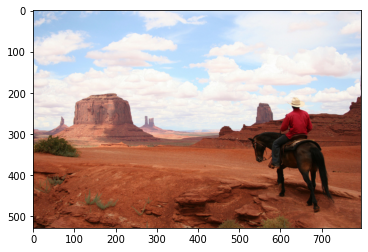

In [26]:
# read the iamge   (take car of png and jpg)
image_path = "../Data/flickr8k/test_examples/horse.png"   
img = Image.open(image_path)

plt.imshow(img)

# start evaluating
model.eval()

# transform image
img = transform(img.convert("RGB")).unsqueeze(0)

print("Caption: "+ " ".join(model.caption_image(img.to(device), dataset.vocab)))